# Лабораторная работа 1
## Решение краевых задач. Методы коллокаций, наименьших квадратов и Галеркина.
### Вариант 15
Методами коллокаций, Галеркина, наименьших квадратов получить численное решение краевой задачи:
$$
{ay''+(1+bx^2)y=-1}
$$
#### Решение

In [22]:
import math
import numpy as np
import scipy.integrate as sp
import matplotlib.pyplot as pl

k = 15
n = 50

def a(x):
    if task == 1:
        return 1
    if task == 2:
        return math.sin(k)
    if task == 3:
        return math.sin(k*x)

def b(x):
    if task == 1:
        return 1
    if task == 2:
        return math.cos(k)
    if task == 3:
        return math.cos(k*x)

def q(x):
    return (1+b(x)*x**2)/a(x)

def show(solve):
    ox = np.linspace(-1, 1, n)
    plain_ox = np.linspace(-1, 1, 100)
    global task
    for task in (1, 2):
        m, v = solve(ox) 
        a_list = np.linalg.solve(m, v)
        pl.plot(plain_ox, [y(x, a_list) for x in plain_ox])
    pl.grid()

Базисные функции заданы следующей формулой:

$\phi_i(x) = x^i(1-x^2), i \in [0, n]$

Вторая производная:

$\phi_i''(x) = (i-1)(i-3)x^{(i-3)}-i(i+1)x^{(i-1)}, i \in [0, n]$

In [2]:
def phi(x, i):
    return (1-x**2)*x**i

def phi_diff2(x, i):
    if i == 0:
        return -2
    if i == 1:
        return -6*x
    return i*x**(i-2)*(i-1) - x**i*(i+1)*(i+2)


По базисным функциям построим приближённое решение:

$y_n(x)=\phi_0(x)+a_1\phi_1(x)+...+a_n\phi_n(x)$


In [3]:
def y(x, a_list):
    return sum(a_list[i]*phi(x, i) for i in range(len(a_list)))


Составим невязку:

$\Psi(x, a_1,..., a_n)=ay_n''(x)+q(x)y_n(x)-f(x)$

## Метод коллокаций


На отрезке $[a, b]$ выберем точки $x_1,...,x_m \in [a, b] (m \ge n)$

Считая, что невязка должна быть нулю в точках коллокации, получим следующую систему для определения коэффициентов $a_1,...,a_n.$

$ \begin{cases}
      \Psi(x_1, a_1,..., a_n)=0,\\
      .....................\\
      \Psi(x_m, a_1,..., a_n)=0.
  \end{cases} $

Для решения данной системы, составим матрицу из коэффициентов при $a_1,...,a_n.$

Коэффициент при $a_j$ в $i$-ой строке выражается следующей формулой:

$ k_{ij}=a(x_i)\phi_j''(x_i) + q(x_i)\phi_j(x_i)$

Свободный член $i$-ой строки выражается следующей формулой:

$ c_i=-1 - a(x_i)\phi_0''(x_i) - q(x_i) \phi_0(x_i)$

In [4]:
def a_coef(x, i):
    return a(x) * phi_diff2(x, i) + q(x) * phi(x, i)

def uni_coef(x, i):
    if i == 0:
        return -2 + q(x)*(1-x*x)
    if i == 1:
        return (-6 + q(x)*(1-x*x))*x
    return x**(i-2)*(i-1)*i - x**i*((i+1)*(i+2) - q(x)*(1-x**2))

def collocations(x_list):
    m = [([uni_coef(x, i) for i in range(n)]) for x in x_list]
    v = [-1 for x in x_list]      
    return np.matrix(m), v

CPU times: user 166 ms, sys: 117 ms, total: 284 ms
Wall time: 103 ms


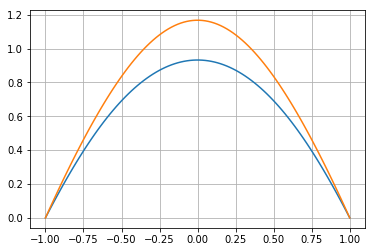

In [5]:
%%time 
show(collocations)

## Метод наименьших квадратов

Выберем $N \gt n$ точек и решим задачу

$S=\sum\limits_{k=1}^N\Psi^2(x_k, a_1,...,a_n) \rightarrow min.$

Для её решения строится система

$ \begin{cases}
      \frac{\partial S}{\partial a_1}=0,\\
      .........\\
      \frac{\partial S}{\partial a_n}=0.
  \end{cases} $
  
Для решения данной системы, составим матрицу из коэффициентов при $a_1,...,a_n.$

Коэффициент при $a_j$ в $i$-ой строке выражается следующей формулой:

$ k_{ij} = 2\cdot\sum\limits_{k=1}^N (a(x)\phi_i''(x_k) + q(x)\phi_i(x_k)) \cdot(a(x)\phi_j''(x_k) + q(x_k)\phi_j(x_k))$

Свободный член $i$-ой строки выражается следующей формулой:

$ c_i= -2\cdot\sum\limits_{k=1}^N (a(x)\phi_i''(x_k) + q(x) \phi_i(x_k))\cdot(a(x)\phi_0''(x_k) + q(x)\phi_0(x_k) + 1)$

In [53]:
def discrete_least_squares(x_list):
    x_list = np.linspace(-1, 1, n*5)
    def coef(i, j):
        return (uni_coef(x_list,j) * uni_coef(x_list,i)).sum()
    def free(i):
        return -(uni_coef(x_list, i)).sum()
  
    v = np.empty((n))
    m = np.empty((n,n))
    for i in range(n):
        for j in range(i+1):
            m[i][j] = m[j][i] = coef(i, j)
        v[i] = free(i)   
    return m, v

CPU times: user 525 ms, sys: 246 ms, total: 771 ms
Wall time: 434 ms


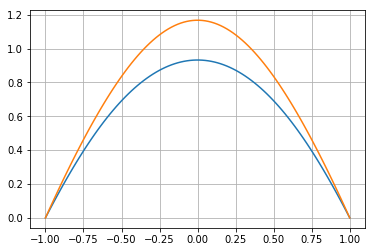

In [54]:
%%time
show(discrete_least_squares)

In [8]:
def integral_least_squares(x_list):
    def coef(i, j):
        return sp.quad(lambda x:uni_coef(x, i) * uni_coef(x, j), -1, 1)[0]
    def free(i):
        return -(sp.quad(lambda x:uni_coef(x, i), -1, 1)[0])
  
    v = np.empty((n))
    m = np.empty((n,n))
    for i in range(n):
        for j in range(i+1):
            m[i][j] = m[j][i] = coef(i, j)
        v[i] = free(i)   
    return m, v

CPU times: user 1.45 s, sys: 111 ms, total: 1.56 s
Wall time: 1.41 s


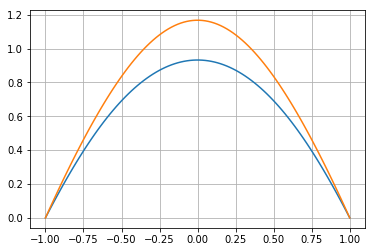

In [9]:
%%time
show(integral_least_squares)

## Метод Галеркина

Составим систему:

$ \begin{cases}
      \int\limits_a^b \Psi(x, a_1,...,a_n)\phi_1(x)dx=0,\\
      .........\\
      \int\limits_a^b \Psi(x, a_1,...,a_n)\phi_n(x)dx=0.
  \end{cases} $
  
Для решения данной системы, составим матрицу из коэффициентов при $a_1,...,a_n.$

Коэффициент при $a_j$ в $i$-ой строке выражается следующей формулой:

$ k_{ij} = \int\limits_a^b a(x)\phi_i(x)\phi_j''(x) dx + \int\limits_a^b q(x)\phi_i(x)\phi_j(x) dx$

Свободный член $i$-ой строки выражается следующей формулой:

$ c_i= - (\int\limits_a^b a(x)\phi_i(x)\phi_0''(x) dx + \int\limits_a^b q(x)\phi_i(x)\phi_0(x) dx + \int\limits_a^b \phi_i(x) dx)$

In [10]:
def galerkin(x_list):
    def coef(i, j):
        return sp.quad(lambda x: uni_coef(x, j)*phi(x, i), -1, 1)[0]
    def free(i):
        return sp.quad(lambda x: -phi(x, i), -1, 1)[0]
    
    m = [([coef(i, j) for j in range(n)]) for i in range(n)]
    v = [free(i) for i in range(n)]  
    return np.matrix(m), v

CPU times: user 1.62 s, sys: 191 ms, total: 1.81 s
Wall time: 1.49 s


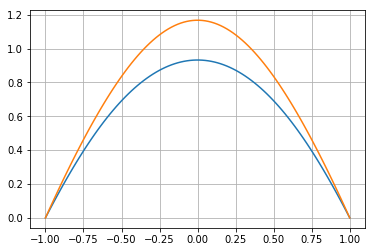

In [11]:
%%time
show(galerkin)

In [13]:
task = 1
n=100
ox = np.linspace(-1, 1, n)
%time collocations(ox)
%time integral_least_squares(ox)
%time discrete_least_squares(ox)
%time galerkin(ox)
pass

CPU times: user 149 ms, sys: 483 µs, total: 150 ms
Wall time: 151 ms
CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2.01 s
CPU times: user 3.98 s, sys: 2.29 ms, total: 3.98 s
Wall time: 3.98 s
CPU times: user 2.31 s, sys: 0 ns, total: 2.31 s
Wall time: 2.32 s
